<a href="https://colab.research.google.com/github/MilaneAndrade/ProjetoK-MeansT3/blob/main/Desafio_K_Means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


##Projeto K-Means

Grupo: 13

Beatriz Ribeiro Santana

Milane Souza Andrade



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.stats import zscore
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer
import zipfile
import os
!pip install matplotlib
!pip install scikit-learn

#1- Preparando os Dados

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Caminho do arquivo carregado
zip_path = "/content/drive/MyDrive/k-means/human+activity+recognition+using+smartphones.zip"
extract_path = "/content/sample_data/zip"

In [4]:
# Descompactar o arquivo
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [5]:
# Listar arquivos extraídos
os.listdir(extract_path)

['UCI HAR Dataset.zip', 'UCI HAR Dataset.names']

In [6]:
# Caminho para o arquivo zipado
zip_path = '/content/sample_data/zip/UCI HAR Dataset.zip' # Substitua com o caminho correto para o arquivo zipado

# Diretório onde o arquivo será descompactado
extract_dir = '/content/sample_data/zip/zip2'

# Descompactando o arquivo
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Verificando o conteúdo da pasta
os.listdir(extract_dir)

['__MACOSX', 'UCI HAR Dataset']

#2- Pré-processando os dados

In [7]:
## Carregando o Dataset:

# Defina o diretório base onde os arquivos foram extraídos
base_dir = '/content/sample_data/zip/zip2/UCI HAR Dataset'

# Carregar os dados de treinamento
X_train = pd.read_csv(os.path.join(base_dir, 'train/X_train.txt'), delim_whitespace=True, header=None)
y_train = pd.read_csv(os.path.join(base_dir, 'train/y_train.txt'), delim_whitespace=True, header=None)



<ipython-input-7-c6a9c120ca7a>:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_train = pd.read_csv(os.path.join(base_dir, 'train/X_train.txt'), delim_whitespace=True, header=None)
<ipython-input-7-c6a9c120ca7a>:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  y_train = pd.read_csv(os.path.join(base_dir, 'train/y_train.txt'), delim_whitespace=True, header=None)


In [8]:
##Normalização dos dados:

# Usando o Robust para normalizar os dados
#scaler_robust = RobustScaler()
#X_train_robust = scaler_robust.fit_transform(X_train)

#scaler = StandardScaler()
#X_train_scaled = scaler.fit_transform(X_train)

min_max_scaler = MinMaxScaler()
X_train_MinMax = min_max_scaler.fit_transform(X_train)

Número de componentes para 78% de variância acumulada: 8


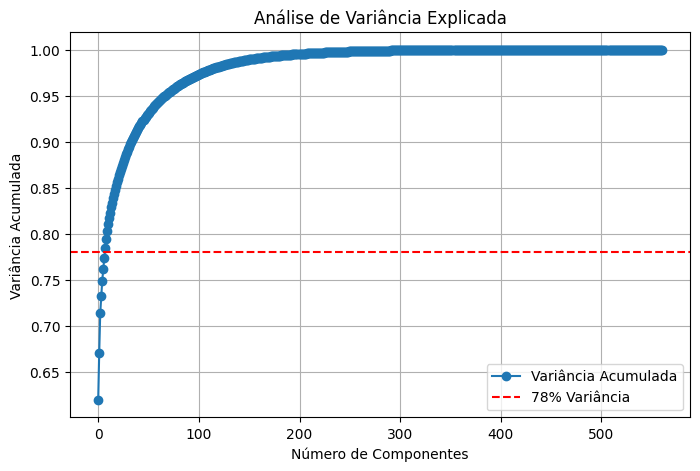

In [9]:
##Aplicação do PCA:


#1 -Aplicando a variância aplicada Acumulada para determinar número do componente do PCA ideal:

#Aplicando PCA
pca_v = PCA()
X_train_pca_v = pca_v.fit_transform(X_train_MinMax)

# Plotando a variância aplicada acumulada
#explained_variance = pca.explained_variance_ratio_.cumsum()
#plt.figure(figsize=(10, 5))
#plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
#plt.xlabel('Número de Componentes')
#plt.ylabel('Variância Aplicada  Acumulada')
#plt.title('Variância Aplicada Acumulada - Nº de Componentes')
#plt.axhline(y=0.80, color='r', linestyle='--', label='Limite de 80% da Variância aplicada')
#plt.legend()
#plt.show()
#print(f"PCA com mais de 80%:",explained_variance[explained_variance >= 0.80])

# Variância Explicada
explained_variance = pca_v.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Encontrar o número de componentes para atingir 78% de variância acumulada
threshold = 0.78  # Percentual desejado
n_components = np.argmax(cumulative_variance >= threshold) + 1  # Índice começa em 0

print(f"Número de componentes para {threshold*100:.0f}% de variância acumulada: {n_components}")

# Gráfico da Variância Acumulada
plt.figure(figsize=(8, 5))
plt.plot(cumulative_variance, marker='o', label="Variância Acumulada")
plt.axhline(y=threshold, color='r', linestyle='--', label=f"{threshold*100:.0f}% Variância")
plt.xlabel("Número de Componentes")
plt.ylabel("Variância Acumulada")
plt.title("Análise de Variância Explicada")
plt.legend()
plt.grid()
plt.show()

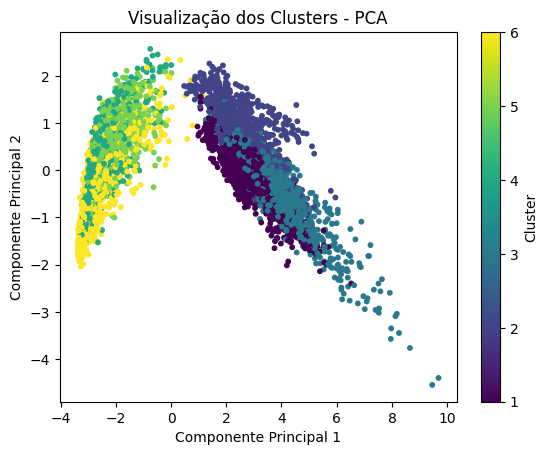

In [16]:
#2 -Redução de Dimensionalidade:

pca= PCA(n_components=min(8, X_train_MinMax.shape[1]))  # Valor dos componentes retirado da variância aplicada
X_train_pca = pca.fit_transform(X_train_MinMax)


plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis', s=10)
plt.title('Visualização dos Clusters - PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(label='Cluster')
plt.show()

In [11]:
##Tratamento de Outliers com Winsorização com Percentis
X_pca_df = pd.DataFrame(X_train_pca)

# Calculando Percentins
lower_percentile = X_pca_df.quantile(0.04, axis=0)  # 4º percentil, calculando para cada coluna
upper_percentile = X_pca_df.quantile(0.96, axis=0)  # 95º percentil, calculando para cada coluna

# Aplicando Winsorização
X_pca_winsorized = X_pca_df.clip(lower=lower_percentile, upper=upper_percentile, axis=1) # Aplicando o corte para cada linha (axis=1), usando os percentis de cada coluna


## 3- Implementação do K-means

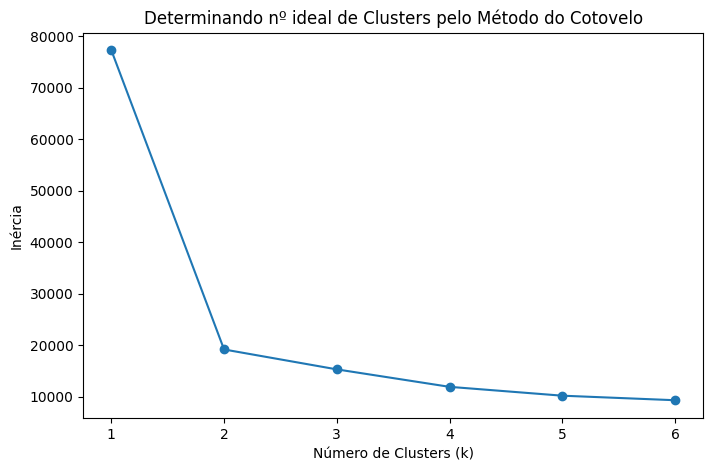

Indice da Silhuette 0.3208264756534511
Número de clusters: 6 Silhouette Score: 0.3208264756534511


In [12]:
  # Determinando o número ideal de clusters usando o método do cotovelo
#1 -Agrupando os dados transformados e suavizados
inertia = []
k_range = range(1, 7) # Testando K de 1 a 7


for k in k_range:
    kmeans = KMeans(n_clusters=k,init='k-means++',random_state=42)
    kmeans.fit(X_pca_winsorized) #Usando os dados já tratados com Outliers
    labels = kmeans.fit_predict(X_pca_winsorized)
    centroides = kmeans.cluster_centers_
    inertia.append(kmeans.inertia_)

#2 -Aplicando método do cotovelo
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia')
plt.title('Determinando nº ideal de Clusters pelo Método do Cotovelo')
plt.show()



#3 -Aplicando Regra e avaliação da Silhuette
score_silhouette= silhouette_score(X_pca_winsorized, labels)
print("Indice da Silhuette",score_silhouette)

silhouette_avg=silhouette_score(X_pca_winsorized, labels)
print(f"Número de clusters:",k,"Silhouette Score:",silhouette_avg)




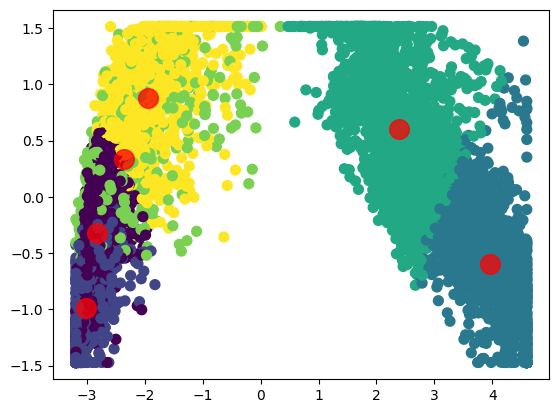

In [13]:
##Consistência dos Clusters após treinamento


#Visualizando o resultado

plt.scatter(X_pca_winsorized.iloc[:,0],X_pca_winsorized.iloc[:,1],c=labels, s=50, cmap='viridis')

plt.scatter(centroides[:, 0], centroides[:, 1], c='red', s=200, alpha=0.75)

plt.show()